* band pass filter for theta, alpha, beta, and gamma -> single epoch
* compute lcmv
* epochs in source space
* envelope on single epoch (envelope = abs(hilbert))
* average envelopes

In [74]:
import mne
import os
import re

os.environ['MNE_3D_OPTION_ANTIALIAS']='false' # to make visualization work

current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

from utils import check_paths

import imageio.v3 as iio

import seaborn as sns

In [ ]:
# ONE CELL THAT RULES THEM ALL

# directories to work with
subjects_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
mris_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\mri'
fsaverage_src_path = os.path.join(mris_dir, 'fsaverage', 'bem', 'fsaverage-ico-5-src.fif')

# dirs to test SR on single subject
subject = 'sub2'
subject_dir = os.path.join(subjects_dir, subject)
# mri_path = os.path.join(mris_dir, subject)
epochs_dir = os.path.join(subject_dir, 'epochs')
epochs_path = os.path.join(epochs_dir, os.listdir(epochs_dir)[0])
trans_path = os.path.join(mris_dir, subject, f'{subject}_trans')

# read epochs and trans files
epochs = mne.read_epochs(epochs_path).pick_types(meg='grad')
info = epochs.info
trans = mne.read_trans(trans_path)

# set frequency bands
epochs_theta = epochs.copy().filter(4., 8.).apply_hilbert(envelope=True)
evoked_theta = epochs_theta.average()

# create source space
src = mne.setup_source_space(
    subject, spacing='oct6', add_dist='patch',
    subjects_dir=mris_dir)
print(src)

# create BEM model
model = mne.make_bem_model(subject=subject, ico=4, #? ico downsampling
                           conductivity=[0.3], # for single layer - suitable for MEG data
                           subjects_dir=mris_dir)
bem = mne.make_bem_solution(model)

# compute the leadfield matrix / forward operator
fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=None,
                                verbose=True)
print(fwd)

In [ ]:
# testing Hilbert transform

cropped_epoch_theta = epochs[0].crop(-0.5, 1.5).pick_types(meg='grad').filter(4., 8.)
cropped_epoch_theta.plot()
hilbert1 = cropped_epoch_theta.apply_hilbert(envelope=True)
hilbert1.plot()
average1 = hilbert1.average()
average1.plot_joint()
average2 = cropped_epoch_theta.average()
average2.plot_joint()
hilbert2 = average2.apply_hilbert(envelope=True)
hilbert2.plot_joint()

In [ ]:
# visualize evoked
#! DON'T ADD TO THE FINAL SCRIPT

evoked_theta.copy().crop(-0.5, 1.5).plot_joint()
evoked_alpha.copy().crop(-0.5, 1.5).plot_joint()
evoked_beta.copy().crop(-0.5, 1.5).plot_joint()
evoked_gamma.copy().crop(-0.5, 1.5).plot_joint()

In [ ]:
# theta ERF

evoked_theta.copy().crop(-0.5, 1.5).plot_joint()
evoked_theta.copy().crop(-0.5, 1.5).apply_hilbert(envelope=True).plot_joint()

In [ ]:
# comparing data covariance matrices from full spectrum epochs and in various freq bands
#! ASKED TOMMASO: USE FULL SPECTRUM

epochs_alpha = epochs.copy().filter(8., 15.).apply_hilbert(envelope=True)
epochs_beta = epochs.copy().filter(15., 30.).apply_hilbert(envelope=True)
epochs_gamma = epochs.copy().filter(30., 60.).apply_hilbert(envelope=True)
evoked_alpha = epochs_alpha.average()
evoked_beta = epochs_beta.average()
evoked_gamma = epochs_gamma.average()

In [ ]:
data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov_theta = mne.compute_covariance(epochs_theta, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov_alpha = mne.compute_covariance(epochs_alpha, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov_beta = mne.compute_covariance(epochs_beta, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov_gamma = mne.compute_covariance(epochs_gamma, tmin=0.01, tmax=1.5,
                                  method='empirical')


In [ ]:
data_cov.plot(epochs.info)
data_cov_theta.plot(epochs_theta.info)
data_cov_alpha.plot(epochs_alpha.info)
data_cov_beta.plot(epochs_beta.info)
data_cov_gamma.plot(epochs_gamma.info)

In [ ]:
# comparing forward solution from epochs (magnetometers) with fwd from epochs (magnetometers) filtered in theta
#! NO DIFFERENCE FOUND
#! fwd from epochs can be used for all frequency bands

from deepdiff import DeepDiff # Deep Difference of dictionaries, iterables, strings and almost any other object. It will recursively look for all the changes.

fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=None,
                                verbose=True)

fwd_theta = mne.make_forward_solution(epochs_theta.info, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=None,
                                verbose=True)
print(fwd)
print(fwd_theta)
DeepDiff(fwd, fwd_theta)

In [ ]:
# compute data covariance
data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov.plot(epochs.info)

In [ ]:
# compute noise covariance from epochs (post-stimulus)
noise_cov_post = mne.compute_covariance(epochs, tmin=3., tmax=3.75,
                                   method='empirical')
noise_cov_post.plot(epochs.info)

In [ ]:
# compute noise covariance from epochs (pre-stimulus)
noise_cov_pre = mne.compute_covariance(epochs, tmin=-1., tmax=-0.01,
                                   method='empirical')
noise_cov_pre.plot(epochs.info)

In [ ]:
# compute noise covariance from empty room
empty_room_path = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\empty_room\\empty_room_tsss.fif'
empty_room_file =  mne.io.read_raw_fif(empty_room_path, preload=True)
empty_room_file = empty_room_file.resample(200)


empty_room_filt = empty_room_file.copy()\
    .filter(l_freq=.5, h_freq=90)\
    .notch_filter(50) # filter data

noise_cov_er = mne.compute_raw_covariance(
    empty_room_filt, tmin=0, tmax=None)
noise_cov_er.plot(epochs.info)

In [ ]:
#! DIRTY CODE
# compute spatial LCMV filter using info from EPOCHS / THETA EPOCHS / THETA EVOKED
#! NO DIFFERENCE
#! USE INFO FROM EPOCHS

filters_epochsi = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov_post, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

filters_epo_theta_i = mne.beamformer.make_lcmv(epochs_theta.info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov_post, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

filters_evo_theta_i = mne.beamformer.make_lcmv(evoked_theta.info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov_post, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

DeepDiff(filters_epochsi.values(), filters_epo_theta_i.values())
DeepDiff(filters_epo_theta_i.values(), filters_evo_theta_i.values())


In [89]:
len(stc_epo_theta_i) == len(stc_evo_theta_i)

True

In [63]:
stc_epochsi[0].data

array([[-0.64086887, -0.30548284, -0.82807553, ...,  0.54243137,
        -2.21143051, -0.71538422],
       [ 0.74867699,  0.00676806,  0.52229854, ..., -0.2050822 ,
         0.07782822,  0.27299651],
       [ 0.20335127,  0.39583998, -0.00368249, ...,  0.11890926,
        -1.77297996, -0.96978129],
       ...,
       [ 0.37447847,  0.8137845 , -0.07126451, ...,  1.32157997,
         0.03290752, -0.31101019],
       [ 0.08765928,  0.14271318, -0.28906334, ..., -0.81165094,
        -1.6689328 , -1.28902103],
       [ 0.19398038,  1.06244294,  0.09604558, ..., -0.56479864,
        -0.55962119, -1.1833501 ]])

In [67]:
import matplotlib.pyplot as plt

In [90]:
array_epochsi = stc_epochsi[0].data
array_epo_theta_i = stc_epo_theta_i[0].data
array_evo_theta_i = stc_evo_theta_i[0].data

In [87]:
array.mean(axis=1).shape

(8192,)

In [84]:
array.shape

(8192, 1100)

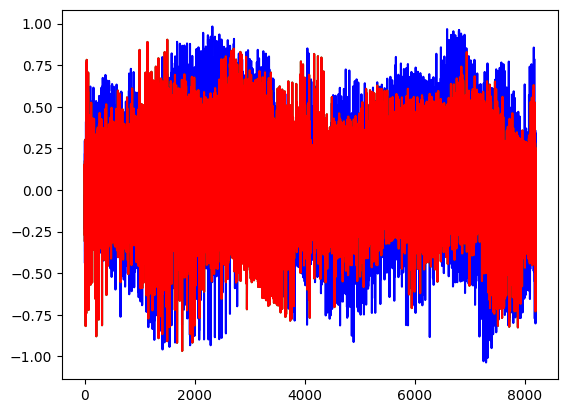

In [96]:
f1 = plt.plot(array_epochsi.mean(axis=1), 'b')
f2 = plt.plot(array_epo_theta_i.mean(axis=1), 'g')
f3 = plt.plot(array_evo_theta_i.mean(axis=1), 'r')

plt.show()

 ...]

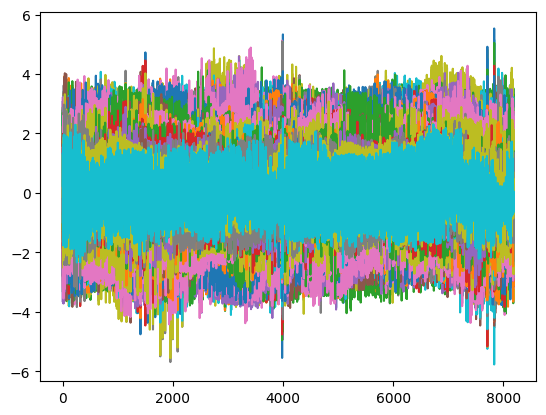

In [79]:
plt.plot(stc_epo_theta_i[0].data)

In [62]:
print(stc_epochsi[0])
print(stc_epo_theta_i[0])
print(stc_evo_theta_i[0])

<SourceEstimate | 8192 vertices, subject : sub2, tmin : -1500.0 (ms), tmax : 3995.0 (ms), tstep : 5.0 (ms), data shape : (8192, 1100), ~68.8 MB>
<SourceEstimate | 8192 vertices, subject : sub2, tmin : -1500.0 (ms), tmax : 3995.0 (ms), tstep : 5.0 (ms), data shape : (8192, 1100), ~68.8 MB>
<SourceEstimate | 8192 vertices, subject : sub2, tmin : -1500.0 (ms), tmax : 3995.0 (ms), tstep : 5.0 (ms), data shape : (8192, 1100), ~68.8 MB>


In [34]:
filters_epo_theta_i

<Beamformer | LCMV, subject "sub2", 8192 vert, 306 ch, max-power ori, unit-noise-gain norm, matrix inversion, rank 80>

In [ ]:
#? INVESTIGATING THE BEAMFORMER
#! DIRTY CODE
# compute spatial LCMV filter on EPOCHS
filters_pre = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov_pre=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

filters_post = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov_post=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)
# apply spatial LCMV filter to EPOCHS
# stc = mne.beamformer.apply_lcmv_epochs(epochs_theta, filters)

In [ ]:
# compute spatial LCMV filter on EVOKED data

# part of the epoch is used for noise covariance
filters = mne.beamformer.make_lcmv(evoked_theta.info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

In [ ]:
# compute spatial LCMV filter

# part of the epoch is used for noise covariance
# filters = mne.beamformer.make_lcmv(evoked_theta.info, fwd, data_cov, reg=0.05,
#                     noise_cov=noise_cov, pick_ori='max-power',
#                     weight_norm='unit-noise-gain', rank=None)

# in case empty room is used for noise covariance
filters = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov_er, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank='info', reduce_rank=True)

# reg=0.05 loading the diagonal of the covariance matrix with 5% of the sensor power

In [100]:
# apply spatial LCMV filter to evoked data
stc = mne.beamformer.apply_lcmv(evoked_theta, filters)

In [ ]:
stc = mne.beamformer.apply_lcmv_epochs(epochs_theta, filters)

In [ ]:
#! find a way to take the envelope of the signal
#! check matrices of different filters for averaged signal or for one epoch
#!!!!!!!!!!
stc_hits = mne.beamformer.apply_lcmv(epochs['hits'].filter(4., 8.).average(), filters) # dipoles x time for condition 1
stc_miss = mne.beamformer.apply_lcmv(epochs['miss'].filter(4., 8.).average(), filters) # dipoles x time for condition 2
stc_diff = stc_hits - stc_miss

In [ ]:
df = stc[0].to_data_frame().drop(['subject', 'time'], axis=1)

In [ ]:

sns.heatmap(df.iloc[[0]], annot=True)

In [ ]:
# in case empty room is used for noise covariance
filters = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov_er, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank='info', reduce_rank=True)

# apply spatial LCMV filter to evoked data
stc = mne.beamformer.apply_lcmv(epochs, filters)

In [ ]:
stc = mne.beamformer.apply_lcmv(epochs.copy().pick_types(meg='grad').filter(4., 8.).apply_hilbert(envelope=True).average(), filters)

In [ ]:
# epochs.copy().filter(4., 8.).apply_hilbert(envelope=True)
epochs =  mne.read_epochs(epochs_path)

In [104]:
stc.data = stc.data * 1000

In [120]:
lims = [0.3, 0.45, 0.6]
kwargs = dict(src=src, subject=subject, subjects_dir=mris_dir,
              initial_time=None, verbose=True)
fig = stc.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)

OverflowError: argument 1 overflowed: value must be in the range -2147483648 to 2147483647

In [90]:
stc_viz = stc.data / 1000

In [93]:
stc.data / 1000 == stc_viz

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [111]:
#! Change the limits for the figure!!!
#!!!!!!!!!!!!!!!
lims = [0, 0.45, 6]
kwargs = dict(src=src, subject=subject, subjects_dir=mris_dir,
              initial_time=None, verbose=True)

fig1 = stc.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)


In [ ]:
filedir = os.path.join(subject_dir, 'movie', 'theta')
check_paths(filedir)

In [ ]:
# visualize the sources and save the movie
# launch only for GROUP analysis

filepath = os.path.join(filedir, 'sources_all_post.mp4')

%matplotlib inline
fig = stc.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)
fig.save_movie(filename=filepath, time_dilation=4.0, tmin=-1.0, tmax=2.0)

In [14]:
type(stc[0])
stc[0]

<SourceEstimate | 8192 vertices, subject : sub2, tmin : -1500.0 (ms), tmax : 3995.0 (ms), tstep : 5.0 (ms), data shape : (8192, 1100), ~68.8 MB>

In [73]:
fig = stc.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)


OverflowError: argument 1 overflowed: value must be in the range -2147483648 to 2147483647